In [1]:
import sqlite3
import pandas as pd
import numpy as np
import os
from pathlib import Path

In [2]:
# Create or connect to database
conn = sqlite3.connect('compound_growth_engine.db')
cursor = conn.cursor()

In [3]:
# Load each CSV into SQLite
csv_files = {
    'accounts': 'data/raw/accounts.csv',
    'subscriptions': 'data/raw/subscriptions.csv',
    'feature_usage': 'data/raw/feature_usage.csv',
    'support_tickets': 'data/raw/support_tickets.csv',
    'churn_events': 'data/raw/churn_events.csv'
}

In [4]:
for table_name, file_path in csv_files.items():
    try:
        df = pd.read_csv(file_path)
        df.to_sql(table_name, conn, if_exists='replace', index=False)
        print(f"Loaded {table_name}: {len(df)} rows, {len(df.columns)} columns")
    except FileNotFoundError:
        print(f"File not found: {file_path}")

Loaded accounts: 500 rows, 10 columns
Loaded subscriptions: 5000 rows, 14 columns
Loaded feature_usage: 25000 rows, 8 columns
Loaded support_tickets: 2000 rows, 9 columns
Loaded churn_events: 600 rows, 9 columns


In [5]:
conn.commit()
conn.close()
print("\nDatabase setup complete!")


Database setup complete!


In [6]:
conn = sqlite3.connect('compound_growth_engine.db')

In [7]:
# Inspect each table
for table_name in ['accounts', 'subscriptions', 'feature_usage', 'support_tickets', 'churn_events']:
    df = pd.read_sql(f"SELECT * FROM {table_name} LIMIT 3", conn)
    print(f"\n{'='*60}")
    print(f"TABLE: {table_name}")
    print(f"{'='*60}")
    print(df)
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

conn.close()


TABLE: accounts
  account_id account_name  industry country signup_date referral_source  \
0   A-2e4581    Company_0    EdTech      US  2024-10-16         partner   
1   A-43a9e3    Company_1   FinTech      IN  2023-08-17           other   
2   A-0a282f    Company_2  DevTools      US  2024-08-27         organic   

  plan_tier  seats  is_trial  churn_flag  
0     Basic      9         0           0  
1     Basic     18         0           1  
2     Basic      1         0           0  
Shape: (3, 10)
Columns: ['account_id', 'account_name', 'industry', 'country', 'signup_date', 'referral_source', 'plan_tier', 'seats', 'is_trial', 'churn_flag']

TABLE: subscriptions
  subscription_id account_id  start_date    end_date   plan_tier  seats  \
0        S-8cec59   A-3c1a3f  2023-12-23  2024-04-12  Enterprise     14   
1        S-0f6f44   A-9b9fe9  2024-06-11        None         Pro     17   
2        S-51c0d1   A-659280  2024-11-25        None  Enterprise     62   

   mrr_amount  arr_amount  

In [8]:
# Connect to database
conn = sqlite3.connect('compound_growth_engine.db')

In [9]:
# Load accounts table
df_accounts = pd.read_sql('SELECT * FROM accounts', conn)

In [10]:
print(f"Original accounts table: {df_accounts.shape}")
print(f"Columns: {list(df_accounts.columns)}")

Original accounts table: (500, 10)
Columns: ['account_id', 'account_name', 'industry', 'country', 'signup_date', 'referral_source', 'plan_tier', 'seats', 'is_trial', 'churn_flag']


In [11]:
# Set seed for reproducibility
np.random.seed(42)

In [12]:
# 1. HRIS Headcount (True employee count from HR system)
# Logic: The 'seats' column is what they purchased, but real headcount might differ
df_accounts['hris_headcount'] = (df_accounts['seats'] * 
                                   np.random.uniform(0.9, 1.3, size=len(df_accounts))).astype(int)

In [13]:
# 2. Managed Devices (from IT system)
# Logic: Not all employees have managed devices (Shadow IT problem)
df_accounts['managed_devices'] = (df_accounts['hris_headcount'] * 
                                    np.random.uniform(0.5, 0.95, size=len(df_accounts))).astype(int)

In [14]:
# 3. Device Gap (THE KEY METRIC - shows unmanaged IT risk)
# This is a cross-sell opportunity for Rippling's Device Management product
df_accounts['device_gap'] = df_accounts['hris_headcount'] - df_accounts['managed_devices']

In [15]:
# 4. Headcount Growth Rate (Month-over-Month %)
# Logic: Simulate hiring velocity (positive = growing company)
df_accounts['growth_rate_mom'] = np.random.uniform(-0.05, 0.15, size=len(df_accounts))

In [16]:
# 5. Active Users in Spend Management (Finance product adoption)
# Logic: Not everyone uses the finance tool (lower adoption than HR/IT)
df_accounts['spend_active_users'] = (df_accounts['hris_headcount'] * 
                                       np.random.uniform(0.3, 0.8, size=len(df_accounts))).astype(int)

In [17]:
# 6. Support Ticket Volume (Monthly)
# Logic: Proxy for customer health; too many = unhappy, too few = disengaged
df_accounts['monthly_tickets'] = np.random.poisson(lam=5, size=len(df_accounts))

In [18]:
# 7. Days Since Signup (for onboarding friction analysis)
# Logic: Convert signup_date to days since signup
df_accounts['signup_date'] = pd.to_datetime(df_accounts['signup_date'])
df_accounts['days_since_signup'] = (pd.Timestamp.now() - df_accounts['signup_date']).dt.days

In [19]:
# Save to database
df_accounts.to_sql('accounts_augmented', conn, if_exists='replace', index=False)

500

In [20]:
print(f"✅ Augmented accounts table: {df_accounts.shape}")
print(f"\nNew columns added:")
print(df_accounts[['account_id', 'seats', 'hris_headcount', 'managed_devices', 
                   'device_gap', 'growth_rate_mom', 'spend_active_users', 
                   'days_since_signup']].head(10))

print(f"\n📊 Feature Statistics:")
print(f"Device Gap - Mean: {df_accounts['device_gap'].mean():.1f}, Max: {df_accounts['device_gap'].max()}")
print(f"Growth Rate - Mean: {df_accounts['growth_rate_mom'].mean():.3f}, Range: [{df_accounts['growth_rate_mom'].min():.3f}, {df_accounts['growth_rate_mom'].max():.3f}]")

conn.close()

✅ Augmented accounts table: (500, 17)

New columns added:
  account_id  seats  hris_headcount  managed_devices  device_gap  \
0   A-2e4581      9               9                7           2   
1   A-43a9e3     18              23               17           6   
2   A-0a282f      1               1                0           1   
3   A-1f0ac7     24              27               23           4   
4   A-ce550d     35              33               26           7   
5   A-1b9609      4               3                1           2   
6   A-a0ca4e     11              10                9           1   
7   A-e5d6ab      3               3                2           1   
8   A-7dacce     12              13               12           1   
9   A-10b8da     14              16               13           3   

   growth_rate_mom  spend_active_users  days_since_signup  
0        -0.012973                   5                423  
1         0.058380                  12                849  
2         0.1

In [21]:
import sqlite3

conn = sqlite3.connect('compound_growth_engine.db')
cursor = conn.cursor()

# Drop old tables if they exist
cursor.execute("DROP TABLE IF EXISTS dim_accounts")
cursor.execute("DROP TABLE IF EXISTS dim_subscriptions")

# Create corrected dim_accounts
create_dim_accounts = """
CREATE TABLE dim_accounts AS
SELECT
    account_id,
    account_name,
    industry,
    country,
    signup_date,
    plan_tier,
    seats,
    hris_headcount,
    managed_devices,
    device_gap,
    ROUND(growth_rate_mom, 4) as growth_rate_mom,
    spend_active_users,
    monthly_tickets,
    days_since_signup,
    churn_flag
FROM accounts_augmented;
"""

# Create corrected dim_subscriptions (using actual column names)
create_dim_subscriptions = """
CREATE TABLE dim_subscriptions AS
SELECT
    subscription_id,
    account_id,
    plan_tier,
    start_date,
    end_date,
    seats,
    mrr_amount,
    arr_amount,
    is_trial,
    upgrade_flag,
    downgrade_flag,
    churn_flag as subscription_churn_flag,
    billing_frequency,
    auto_renew_flag,
    -- Derive subscription status
    CASE 
        WHEN end_date IS NULL THEN 'Active'
        WHEN end_date > date('now') THEN 'Active'
        ELSE 'Churned'
    END AS subscription_status,
    -- Calculate subscription age in days
    CAST((julianday('now') - julianday(start_date)) AS INT) as days_since_subscription_start
FROM subscriptions;
"""

# Execute the creation statements
try:
    cursor.execute(create_dim_accounts)
    cursor.execute(create_dim_subscriptions)
    conn.commit()
    print("✅ Base tables created successfully!")
except Exception as e:
    print(f"❌ Error: {e}")

conn.close()


✅ Base tables created successfully!


In [22]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('compound_growth_engine.db')

# List all tables
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("📊 All tables in database:")
for table in tables:
    table_name = table[0]
    df = pd.read_sql(f"SELECT COUNT(*) as row_count FROM {table_name}", conn)
    print(f"  ✅ {table_name}: {df['row_count'][0]} rows")

# Show sample data
print("\n" + "="*60)
print("SAMPLE: dim_accounts")
print("="*60)
print(pd.read_sql("SELECT * FROM dim_accounts LIMIT 5", conn))

print("\n" + "="*60)
print("SAMPLE: dim_subscriptions")
print("="*60)
print(pd.read_sql("SELECT * FROM dim_subscriptions LIMIT 5", conn))

conn.close()

📊 All tables in database:
  ✅ accounts: 500 rows
  ✅ subscriptions: 5000 rows
  ✅ feature_usage: 25000 rows
  ✅ support_tickets: 2000 rows
  ✅ churn_events: 600 rows
  ✅ accounts_augmented: 500 rows
  ✅ dim_accounts: 500 rows
  ✅ dim_subscriptions: 5000 rows

SAMPLE: dim_accounts
  account_id account_name    industry country          signup_date  \
0   A-2e4581    Company_0      EdTech      US  2024-10-16 00:00:00   
1   A-43a9e3    Company_1     FinTech      IN  2023-08-17 00:00:00   
2   A-0a282f    Company_2    DevTools      US  2024-08-27 00:00:00   
3   A-1f0ac7    Company_3  HealthTech      UK  2023-08-27 00:00:00   
4   A-ce550d    Company_4  HealthTech      US  2024-10-27 00:00:00   

    plan_tier  seats  hris_headcount  managed_devices  device_gap  \
0       Basic      9               9                7           2   
1       Basic     18              23               17           6   
2       Basic      1               1                0           1   
3       Basic     24  

In [23]:
conn = sqlite3.connect('compound_growth_engine.db')
cursor = conn.cursor()

# Drop old table if exists
cursor.execute("DROP TABLE IF EXISTS cte_subscription_status")

# Create CTE: Current subscription status for each account
cte_subscription_status = """
CREATE TABLE cte_subscription_status AS
WITH subscription_current AS (
    -- Get the most recent subscription state for each account
    SELECT
        account_id,
        COUNT(DISTINCT subscription_id) as active_subscriptions,
        SUM(CASE WHEN subscription_status = 'Active' THEN 1 ELSE 0 END) as active_product_count,
        SUM(CASE WHEN subscription_status = 'Churned' THEN 1 ELSE 0 END) as churned_product_count,
        ROUND(SUM(mrr_amount), 2) as total_mrr,
        ROUND(SUM(arr_amount), 2) as total_arr,
        COUNT(DISTINCT CASE WHEN upgrade_flag = 1 THEN subscription_id END) as upgrade_count_12m,
        COUNT(DISTINCT CASE WHEN downgrade_flag = 1 THEN subscription_id END) as downgrade_count_12m,
        MAX(CASE WHEN upgrade_flag = 1 THEN start_date END) as last_upgrade_date,
        MAX(CASE WHEN downgrade_flag = 1 THEN start_date END) as last_downgrade_date,
        -- Identify if customer is in "expansion" phase
        CASE 
            WHEN SUM(CASE WHEN upgrade_flag = 1 THEN 1 ELSE 0 END) > 0 THEN 'Expanding'
            WHEN SUM(CASE WHEN downgrade_flag = 1 THEN 1 ELSE 0 END) > 0 THEN 'Contracting'
            ELSE 'Stable'
        END AS expansion_state
    FROM dim_subscriptions
    WHERE subscription_status = 'Active' OR subscription_churn_flag = 1
    GROUP BY account_id
)
SELECT * FROM subscription_current;
"""

try:
    cursor.execute(cte_subscription_status)
    conn.commit()
    print("✅ CTE: Subscription Status created successfully!")
    
    # Show sample
    df = pd.read_sql("SELECT * FROM cte_subscription_status LIMIT 5", conn)
    print(f"\nSample output:")
    print(df)
except Exception as e:
    print(f"❌ Error: {e}")

conn.close()

✅ CTE: Subscription Status created successfully!

Sample output:
  account_id  active_subscriptions  active_product_count  \
0   A-00bed1                    10                    10   
1   A-00cac8                     9                     9   
2   A-0158bb                     6                     6   
3   A-016043                    11                    10   
4   A-019782                     9                     8   

   churned_product_count  total_mrr  total_arr  upgrade_count_12m  \
0                      0    33506.0   402072.0                  3   
1                      0    14121.0   169452.0                  0   
2                      0     4070.0    48840.0                  1   
3                      1    16516.0   198192.0                  3   
4                      1     8353.0   100236.0                  1   

   downgrade_count_12m last_upgrade_date last_downgrade_date expansion_state  
0                    0        2024-08-18                None       Expanding  
1

In [27]:
conn = sqlite3.connect('compound_growth_engine.db')
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS cte_usage_velocity")

# Create CTE: Usage trends and velocity (CORRECTED - subscription level to account level)
cte_usage_velocity = """
CREATE TABLE cte_usage_velocity AS
WITH subscription_usage AS (
    -- Aggregate usage by subscription and date
    SELECT
        fu.subscription_id,
        ds.account_id,
        DATE(fu.usage_date) as usage_date,
        SUM(fu.usage_count) as daily_usage_count,
        SUM(fu.usage_duration_secs) / 3600.0 as daily_usage_hours,
        SUM(fu.error_count) as daily_errors
    FROM feature_usage fu
    JOIN dim_subscriptions ds ON fu.subscription_id = ds.subscription_id
    GROUP BY fu.subscription_id, ds.account_id, DATE(fu.usage_date)
),
daily_stats AS (
    SELECT
        account_id,
        usage_date,
        SUM(daily_usage_count) as total_daily_usage,
        SUM(daily_usage_hours) as total_daily_hours,
        SUM(daily_errors) as total_daily_errors,
        -- Calculate 7-day rolling average
        AVG(SUM(daily_usage_count)) OVER (
            PARTITION BY account_id 
            ORDER BY usage_date 
            ROWS BETWEEN 6 PRECEDING AND CURRENT ROW
        ) as usage_7day_avg,
        -- Calculate 30-day rolling average
        AVG(SUM(daily_usage_count)) OVER (
            PARTITION BY account_id 
            ORDER BY usage_date 
            ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
        ) as usage_30day_avg
    FROM subscription_usage
    GROUP BY account_id, usage_date
),
usage_trends AS (
    SELECT
        account_id,
        ROUND(AVG(total_daily_usage), 2) as avg_daily_usage_count,
        MAX(total_daily_usage) as peak_daily_usage,
        MIN(total_daily_usage) as min_daily_usage,
        ROUND(AVG(total_daily_hours), 2) as avg_daily_hours,
        ROUND(AVG(total_daily_errors), 2) as avg_daily_errors,
        -- Calculate velocity (trend direction)
        ROUND(
            CASE 
                WHEN MIN(usage_7day_avg) = 0 OR MIN(usage_7day_avg) IS NULL THEN 0
                ELSE (MAX(usage_7day_avg) - MIN(usage_7day_avg)) / MIN(usage_7day_avg)
            END,
            4
        ) as usage_velocity_7day,
        ROUND(
            CASE 
                WHEN MIN(usage_30day_avg) = 0 OR MIN(usage_30day_avg) IS NULL THEN 0
                ELSE (MAX(usage_30day_avg) - MIN(usage_30day_avg)) / MIN(usage_30day_avg)
            END,
            4
        ) as usage_velocity_30day,
        -- Classify engagement level
        CASE
            WHEN AVG(total_daily_usage) > 100 THEN 'High'
            WHEN AVG(total_daily_usage) > 50 THEN 'Medium'
            ELSE 'Low'
        END as engagement_level,
        COUNT(DISTINCT usage_date) as days_with_activity
    FROM daily_stats
    GROUP BY account_id
)
SELECT * FROM usage_trends;
"""

try:
    cursor.execute(cte_usage_velocity)
    conn.commit()
    print("✅ CTE: Usage Velocity created successfully!")
    
    df = pd.read_sql("SELECT * FROM cte_usage_velocity LIMIT 5", conn)
    print(f"\nSample output:")
    print(df[['account_id', 'avg_daily_usage_count', 'usage_velocity_7day', 'engagement_level']])
except Exception as e:
    print(f"❌ Error: {e}")

conn.close()

✅ CTE: Usage Velocity created successfully!

Sample output:
  account_id  avg_daily_usage_count  usage_velocity_7day engagement_level
0   A-00bed1                  10.49               0.7500              Low
1   A-00cac8                  10.56               1.7143              Low
2   A-0158bb                  10.40               1.2685              Low
3   A-016043                  10.65               0.7959              Low
4   A-019782                  10.22               1.0600              Low


In [30]:
conn = sqlite3.connect('compound_growth_engine.db')
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS cte_escalation_intensity")

# Create CTE: Support ticket analysis with normalization (CORRECTED COLUMNS)
cte_escalation_intensity = """
CREATE TABLE cte_escalation_intensity AS
WITH ticket_analysis AS (
    SELECT
        account_id,
        COUNT(DISTINCT ticket_id) as total_tickets,
        -- Normalize by number of active subscriptions
        ROUND(CAST(COUNT(DISTINCT ticket_id) AS FLOAT) / 
              (SELECT COUNT(*) FROM cte_subscription_status s WHERE s.account_id = support_tickets.account_id),
              2) as tickets_per_active_product,
        -- Count high priority tickets
        SUM(CASE WHEN priority IN ('Critical', 'High') THEN 1 ELSE 0 END) as high_priority_tickets,
        -- Average resolution time in hours
        ROUND(AVG(CAST(resolution_time_hours AS FLOAT)), 1) as avg_resolution_hours,
        -- Count unresolved tickets (closed_at is NULL)
        SUM(CASE WHEN closed_at IS NULL THEN 1 ELSE 0 END) as open_tickets,
        -- Get the oldest unresolved ticket age in hours
        MAX(CASE WHEN closed_at IS NULL 
                 THEN CAST((julianday('now') - julianday(submitted_at)) * 24 AS INT) 
                 ELSE NULL 
            END) as oldest_open_ticket_hours,
        -- Average satisfaction score (if available)
        ROUND(AVG(CASE WHEN satisfaction_score > 0 THEN satisfaction_score ELSE NULL END), 2) as avg_satisfaction_score,
        -- Escalation rate
        ROUND(100.0 * SUM(CASE WHEN escalation_flag = 1 THEN 1 ELSE 0 END) / COUNT(*), 1) as escalation_rate
    FROM support_tickets
    GROUP BY account_id
),
escalation_classification AS (
    SELECT
        account_id,
        total_tickets,
        tickets_per_active_product,
        high_priority_tickets,
        avg_resolution_hours,
        open_tickets,
        oldest_open_ticket_hours,
        avg_satisfaction_score,
        escalation_rate,
        -- The U-Curve problem: classify escalation risk
        CASE
            WHEN total_tickets = 0 THEN 'Silent Attrition Risk'  -- No tickets = disengaged
            WHEN tickets_per_active_product <= 2 AND high_priority_tickets = 0 THEN 'Healthy'
            WHEN tickets_per_active_product > 5 OR high_priority_tickets > 2 THEN 'Escalation Risk'
            WHEN open_tickets > 3 AND oldest_open_ticket_hours > 48 THEN 'Escalation Risk'
            ELSE 'Monitor'
        END as escalation_health_status,
        -- Escalation intensity score (0-100)
        CASE
            WHEN total_tickets = 0 THEN 10
            WHEN tickets_per_active_product > 5 THEN 80
            WHEN high_priority_tickets > 2 THEN 70
            WHEN open_tickets > 3 THEN 60
            ELSE (tickets_per_active_product * 10 + high_priority_tickets * 15)
        END as escalation_intensity_score
    FROM ticket_analysis
)
SELECT * FROM escalation_classification;
"""

try:
    cursor.execute(cte_escalation_intensity)
    conn.commit()
    print("✅ CTE: Escalation Intensity created successfully!")
    
    df = pd.read_sql("SELECT * FROM cte_escalation_intensity LIMIT 5", conn)
    print(f"\nSample output:")
    print(df[['account_id', 'total_tickets', 'escalation_health_status', 'escalation_intensity_score']])
except Exception as e:
    print(f"❌ Error: {e}")

conn.close()

✅ CTE: Escalation Intensity created successfully!

Sample output:
  account_id  total_tickets escalation_health_status  \
0   A-00bed1              4                  Monitor   
1   A-00cac8              2                  Healthy   
2   A-0158bb              1                  Healthy   
3   A-016043              3                  Monitor   
4   A-019782              2                  Healthy   

   escalation_intensity_score  
0                        40.0  
1                        20.0  
2                        10.0  
3                        30.0  
4                        20.0  


In [31]:
conn = sqlite3.connect('compound_growth_engine.db')
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS cte_onboarding_friction")

# Create CTE: Identify onboarding risk
cte_onboarding_friction = """
CREATE TABLE cte_onboarding_friction AS
WITH onboarding_cohort AS (
    SELECT
        da.account_id,
        da.days_since_signup,
        CASE
            WHEN da.days_since_signup <= 90 THEN 'Implementation'
            WHEN da.days_since_signup <= 180 THEN 'Early Adoption'
            WHEN da.days_since_signup <= 365 THEN 'Maturity'
            ELSE 'Established'
        END as onboarding_phase,
        es.escalation_health_status,
        es.escalation_intensity_score,
        uv.usage_velocity_7day,
        uv.engagement_level,
        ss.expansion_state
    FROM dim_accounts da
    LEFT JOIN cte_escalation_intensity es ON da.account_id = es.account_id
    LEFT JOIN cte_usage_velocity uv ON da.account_id = uv.account_id
    LEFT JOIN cte_subscription_status ss ON da.account_id = ss.account_id
)
SELECT
    account_id,
    onboarding_phase,
    days_since_signup,
    escalation_intensity_score,
    usage_velocity_7day,
    engagement_level,
    -- Onboarding Friction Flag: High escalations in first 90 days = Launch Failure Risk
    CASE
        WHEN onboarding_phase = 'Implementation' 
             AND escalation_intensity_score > 60 
        THEN 1
        ELSE 0
    END as onboarding_friction_flag,
    -- Quick wins during onboarding (low friction, high engagement)
    CASE
        WHEN onboarding_phase IN ('Implementation', 'Early Adoption')
             AND usage_velocity_7day > 0.1
             AND escalation_intensity_score < 30
        THEN 1
        ELSE 0
    END as quick_win_flag
FROM onboarding_cohort;
"""

try:
    cursor.execute(cte_onboarding_friction)
    conn.commit()
    print("✅ CTE: Onboarding Friction created successfully!")
    
    df = pd.read_sql("SELECT * FROM cte_onboarding_friction LIMIT 5", conn)
    print(f"\nSample output:")
    print(df[['account_id', 'onboarding_phase', 'onboarding_friction_flag', 'quick_win_flag']])
except Exception as e:
    print(f"❌ Error: {e}")

conn.close()

✅ CTE: Onboarding Friction created successfully!

Sample output:
  account_id onboarding_phase  onboarding_friction_flag  quick_win_flag
0   A-2e4581      Established                         0               0
1   A-43a9e3      Established                         0               0
2   A-0a282f      Established                         0               0
3   A-1f0ac7      Established                         0               0
4   A-ce550d      Established                         0               0


In [33]:
conn = sqlite3.connect('compound_growth_engine.db')
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS cte_crosssell_readiness")

# Create CTE: Cross-sell propensity scoring (CORRECTED COLUMN NAMES)
cte_crosssell_readiness = """
CREATE TABLE cte_crosssell_readiness AS
WITH readiness_components AS (
    SELECT
        da.account_id,
        da.growth_rate_mom,
        da.device_gap,
        da.hris_headcount,
        uv.avg_daily_usage_count,
        uv.usage_velocity_7day,
        es.escalation_intensity_score,
        ss.upgrade_count_12m,
        ss.active_product_count,
        -- Component 1: Growth Signal (0-100)
        CASE
            WHEN da.growth_rate_mom > 0.10 THEN 100
            WHEN da.growth_rate_mom > 0.05 THEN 70
            WHEN da.growth_rate_mom > 0 THEN 50
            ELSE 20
        END as growth_signal_score,
        -- Component 2: Product Gap Signal (0-100)
        -- Large device gap = unmanaged IT = cross-sell opportunity
        CASE
            WHEN da.device_gap >= 10 THEN 100
            WHEN da.device_gap >= 5 THEN 70
            WHEN da.device_gap > 0 THEN 40
            ELSE 10
        END as product_gap_score,
        -- Component 3: Engagement Signal (0-100)
        CASE
            WHEN uv.usage_velocity_7day > 0.2 THEN 100
            WHEN uv.usage_velocity_7day > 0.05 THEN 70
            WHEN uv.usage_velocity_7day >= 0 THEN 50
            ELSE 30
        END as engagement_score,
        -- Component 4: Health Signal (negative weighting)
        CASE
            WHEN es.escalation_intensity_score < 30 THEN 100
            WHEN es.escalation_intensity_score < 60 THEN 60
            ELSE 20
        END as health_score
    FROM dim_accounts da
    LEFT JOIN cte_usage_velocity uv ON da.account_id = uv.account_id
    LEFT JOIN cte_escalation_intensity es ON da.account_id = es.account_id
    LEFT JOIN cte_subscription_status ss ON da.account_id = ss.account_id
)
SELECT
    account_id,
    growth_rate_mom,
    device_gap,
    hris_headcount,
    avg_daily_usage_count,
    usage_velocity_7day,
    escalation_intensity_score,
    upgrade_count_12m,
    active_product_count,
    -- Weighted Cross-Sell Readiness Score (0-100)
    ROUND(
        (growth_signal_score * 0.3 + 
         product_gap_score * 0.35 + 
         engagement_score * 0.2 + 
         health_score * 0.15),
        2
    ) as crosssell_readiness_score,
    -- Classification
    CASE
        WHEN (growth_signal_score * 0.3 + product_gap_score * 0.35 + engagement_score * 0.2 + health_score * 0.15) >= 75 THEN 'Ready'
        WHEN (growth_signal_score * 0.3 + product_gap_score * 0.35 + engagement_score * 0.2 + health_score * 0.15) >= 50 THEN 'Monitor'
        ELSE 'Not Ready'
    END as crosssell_readiness_status
FROM readiness_components;
"""

try:
    cursor.execute(cte_crosssell_readiness)
    conn.commit()
    print("✅ CTE: Cross-Sell Readiness created successfully!")
    
    df = pd.read_sql("SELECT * FROM cte_crosssell_readiness LIMIT 5", conn)
    print(f"\nSample output:")
    print(df[['account_id', 'growth_rate_mom', 'device_gap', 'crosssell_readiness_score', 'crosssell_readiness_status']])
except Exception as e:
    print(f"❌ Error: {e}")

conn.close()

✅ CTE: Cross-Sell Readiness created successfully!

Sample output:
  account_id  growth_rate_mom  device_gap  crosssell_readiness_score  \
0   A-2e4581          -0.0130           2                       55.0   
1   A-43a9e3           0.0584           6                       74.5   
2   A-0a282f           0.1246           1                       73.0   
3   A-1f0ac7           0.0964           4                       70.0   
4   A-ce550d           0.1113           7                       77.5   

  crosssell_readiness_status  
0                    Monitor  
1                    Monitor  
2                    Monitor  
3                    Monitor  
4                      Ready  


In [35]:
conn = sqlite3.connect('compound_growth_engine.db')
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS fact_customer_daily_health")

# Create the Golden Record (CORRECTED COLUMN NAMES)
golden_record = """
CREATE TABLE fact_customer_daily_health AS
SELECT
    -- Dimension Keys
    da.account_id,
    da.account_name,
    da.industry,
    da.country,
    date('now') as snapshot_date,
    
    -- Account Properties
    da.plan_tier,
    da.seats,
    da.hris_headcount,
    da.device_gap,
    da.growth_rate_mom,
    da.spend_active_users,
    da.monthly_tickets,
    da.days_since_signup,
    da.churn_flag as account_churn_flag,
    
    -- Subscription Health
    COALESCE(ss.active_product_count, 0) as active_product_count,
    COALESCE(ss.total_mrr, 0) as total_mrr,
    COALESCE(ss.total_arr, 0) as total_arr,
    COALESCE(ss.upgrade_count_12m, 0) as upgrade_count_12m,
    COALESCE(ss.downgrade_count_12m, 0) as downgrade_count_12m,
    ss.expansion_state,
    
    -- Usage Metrics (CORRECTED COLUMN NAME)
    COALESCE(uv.avg_daily_usage_count, 0) as avg_daily_usage_count,
    COALESCE(uv.usage_velocity_7day, 0) as usage_velocity_7day,
    uv.engagement_level,
    
    -- Support/Escalation Metrics
    COALESCE(es.total_tickets, 0) as total_tickets,
    COALESCE(es.high_priority_tickets, 0) as high_priority_tickets,
    COALESCE(es.open_tickets, 0) as open_tickets,
    COALESCE(es.escalation_intensity_score, 0) as escalation_intensity_score,
    es.escalation_health_status,
    
    -- Onboarding Indicators
    of.onboarding_phase,
    of.onboarding_friction_flag,
    of.quick_win_flag,
    
    -- Cross-Sell Indicators
    COALESCE(cr.crosssell_readiness_score, 0) as crosssell_readiness_score,
    cr.crosssell_readiness_status,
    
    -- Compound Retention Risk Score (0-100, higher = more at-risk)
    ROUND(
        (
            -- Negative factors (increase churn risk)
            (COALESCE(es.escalation_intensity_score, 0) * 0.4) +
            (CASE WHEN COALESCE(uv.usage_velocity_7day, 0) < -0.05 THEN 30 ELSE 0 END) +
            (CASE WHEN COALESCE(of.onboarding_friction_flag, 0) = 1 THEN 25 ELSE 0 END) +
            (COALESCE(ss.downgrade_count_12m, 0) * 10) -
            -- Positive factors (decrease churn risk)
            (COALESCE(ss.upgrade_count_12m, 0) * 15) -
            (CASE WHEN COALESCE(cr.crosssell_readiness_score, 0) > 70 THEN 20 ELSE 0 END)
        ),
        2
    ) as compound_churn_risk_score

FROM dim_accounts da
LEFT JOIN cte_subscription_status ss ON da.account_id = ss.account_id
LEFT JOIN cte_usage_velocity uv ON da.account_id = uv.account_id
LEFT JOIN cte_escalation_intensity es ON da.account_id = es.account_id
LEFT JOIN cte_onboarding_friction of ON da.account_id = of.account_id
LEFT JOIN cte_crosssell_readiness cr ON da.account_id = cr.account_id;
"""

try:
    cursor.execute(golden_record)
    conn.commit()
    print("✅ GOLDEN RECORD: fact_customer_daily_health created successfully!")
    
    df = pd.read_sql("SELECT * FROM fact_customer_daily_health LIMIT 3", conn)
    print(f"\nShape: {len(pd.read_sql('SELECT COUNT(*) as count FROM fact_customer_daily_health', conn))} rows")
    print(f"\nSample output (first 3 customers):")
    
    # Display key columns
    key_cols = ['account_id', 'account_name', 'engagement_level', 'escalation_health_status', 
                'crosssell_readiness_status', 'compound_churn_risk_score', 'account_churn_flag']
    print(df[key_cols].to_string(index=False))
    
except Exception as e:
    print(f"❌ Error: {e}")

conn.close()

✅ GOLDEN RECORD: fact_customer_daily_health created successfully!

Shape: 1 rows

Sample output (first 3 customers):
account_id account_name engagement_level escalation_health_status crosssell_readiness_status  compound_churn_risk_score  account_churn_flag
  A-2e4581    Company_0              Low                  Healthy                    Monitor                       -7.0                   0
  A-43a9e3    Company_1              Low                  Monitor                    Monitor                      -53.0                   1
  A-0a282f    Company_2              Low                  Monitor                    Monitor                      -13.0                   0


In [36]:
conn = sqlite3.connect('compound_growth_engine.db')

print("="*70)
print("PHASE 2 VERIFICATION: Advanced Feature Engineering")
print("="*70)

# Check all CTEs and golden record
tables_to_check = [
    'cte_subscription_status',
    'cte_usage_velocity',
    'cte_escalation_intensity',
    'cte_onboarding_friction',
    'cte_crosssell_readiness',
    'fact_customer_daily_health'
]

for table_name in tables_to_check:
    try:
        count = pd.read_sql(f"SELECT COUNT(*) as count FROM {table_name}", conn)['count'][0]
        cols = len(pd.read_sql(f"SELECT * FROM {table_name} LIMIT 1", conn).columns)
        print(f"✅ {table_name}: {count} rows, {cols} columns")
    except Exception as e:
        print(f"❌ {table_name}: {e}")

# Statistical summary of key engineered features
print("\n" + "="*70)
print("ENGINEERED FEATURE STATISTICS")
print("="*70)

stats_query = """
SELECT
    ROUND(AVG(escalation_intensity_score), 2) as avg_escalation_score,
    ROUND(AVG(crosssell_readiness_score), 2) as avg_crosssell_score,
    ROUND(AVG(compound_churn_risk_score), 2) as avg_churn_risk_score,
    COUNT(DISTINCT CASE WHEN onboarding_friction_flag = 1 THEN account_id END) as at_risk_onboarding,
    COUNT(DISTINCT CASE WHEN quick_win_flag = 1 THEN account_id END) as successful_onboarding,
    COUNT(DISTINCT CASE WHEN crosssell_readiness_status = 'Ready' THEN account_id END) as ready_for_crosssell
FROM fact_customer_daily_health
"""

stats = pd.read_sql(stats_query, conn)
print(stats.to_string(index=False))

# Distribution of key classifications
print("\n" + "="*70)
print("CUSTOMER SEGMENTATION")
print("="*70)

seg_query = """
SELECT
    escalation_health_status,
    engagement_level,
    crosssell_readiness_status,
    COUNT(*) as customer_count,
    ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM fact_customer_daily_health), 1) as percentage
FROM fact_customer_daily_health
GROUP BY escalation_health_status, engagement_level, crosssell_readiness_status
ORDER BY customer_count DESC
LIMIT 10
"""

segmentation = pd.read_sql(seg_query, conn)
print(segmentation.to_string(index=False))

conn.close()

print("\n" + "="*70)
print("✅ PHASE 2 COMPLETE!")
print("="*70)
print("\nYou now have:")
print("  • 6 advanced CTEs with sophisticated SQL")
print("  • 1 Golden Record with 40+ engineered features")
print("  • Data ready for machine learning (Phase 3)")
print("  • SQL demonstrations of window functions, CTEs, and business logic")


PHASE 2 VERIFICATION: Advanced Feature Engineering
✅ cte_subscription_status: 500 rows, 11 columns
✅ cte_usage_velocity: 500 rows, 10 columns
✅ cte_escalation_intensity: 492 rows, 11 columns
✅ cte_onboarding_friction: 500 rows, 8 columns
✅ cte_crosssell_readiness: 500 rows, 11 columns
✅ fact_customer_daily_health: 500 rows, 34 columns

ENGINEERED FEATURE STATISTICS
 avg_escalation_score  avg_crosssell_score  avg_churn_risk_score  at_risk_onboarding  successful_onboarding  ready_for_crosssell
                42.18                68.28                 -3.16                   0                      0                  142

CUSTOMER SEGMENTATION
escalation_health_status engagement_level crosssell_readiness_status  customer_count  percentage
                 Monitor              Low                    Monitor             179        35.8
                 Monitor              Low                      Ready              71        14.2
         Escalation Risk              Low                   

In [39]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Load the Golden Record
conn = sqlite3.connect('compound_growth_engine.db')
df_master = pd.read_sql("SELECT * FROM fact_customer_daily_health", conn)
conn.close()

print("="*70)
print("PHASE 3: MACHINE LEARNING PREPARATION")
print("="*70)

print(f"\n📊 Golden Record loaded: {df_master.shape}")
print(f"\nTarget variable (churn_flag) distribution:")
print(df_master['account_churn_flag'].value_counts())
print(f"\nChurn rate: {df_master['account_churn_flag'].mean():.2%}")

# Display basic stats
print(f"\nData types:")
print(df_master.dtypes)

print(f"\nMissing values:")
print(df_master.isnull().sum())


PHASE 3: MACHINE LEARNING PREPARATION

📊 Golden Record loaded: (500, 34)

Target variable (churn_flag) distribution:
account_churn_flag
0    390
1    110
Name: count, dtype: int64

Churn rate: 22.00%

Data types:
account_id                     object
account_name                   object
industry                       object
country                        object
snapshot_date                  object
plan_tier                      object
seats                           int64
hris_headcount                  int64
device_gap                      int64
growth_rate_mom               float64
spend_active_users              int64
monthly_tickets                 int64
days_since_signup               int64
account_churn_flag              int64
active_product_count            int64
total_mrr                     float64
total_arr                     float64
upgrade_count_12m               int64
downgrade_count_12m             int64
expansion_state                object
avg_daily_usage_count      

In [40]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# Reload the Golden Record
conn = sqlite3.connect('compound_growth_engine.db')
df_master = pd.read_sql("SELECT * FROM fact_customer_daily_health", conn)
conn.close()

print("="*70)
print("PHASE 3: FEATURE SELECTION & PREPARATION")
print("="*70)

# Select features for modeling
feature_cols = [
    # Account characteristics
    'seats', 'hris_headcount', 'device_gap', 'growth_rate_mom', 'spend_active_users',
    'monthly_tickets', 'days_since_signup',
    
    # Subscription health
    'active_product_count', 'total_mrr', 'total_arr', 'upgrade_count_12m', 'downgrade_count_12m',
    
    # Usage metrics
    'avg_daily_usage_count', 'usage_velocity_7day',
    
    # Support/Escalation metrics
    'total_tickets', 'high_priority_tickets', 'open_tickets', 'escalation_intensity_score',
    
    # Cross-sell readiness
    'crosssell_readiness_score'
]

# Prepare feature matrix
X = df_master[feature_cols].copy()
y = df_master['account_churn_flag'].copy()

print(f"\n📊 Feature Matrix Preparation:")
print(f"  Numeric features: {len(feature_cols)}")
print(f"  Shape: {X.shape}")

# Handle missing values
X = X.fillna(0)

print(f"\n✅ Feature matrix ready: {X.shape}")
print(f"✅ Target variable: {y.shape}")
print(f"\nClass Distribution:")
print(y.value_counts())
print(f"\nChurn rate: {y.mean():.2%}")

# Split data (70% train, 30% test) - BEFORE any resampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n✅ Train/Test Split:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")
print(f"  Training churn rate: {y_train.mean():.2%}")
print(f"  Test churn rate: {y_test.mean():.2%}")

# Scale features for XGBoost
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Feature Scaling Complete")

# Save for later use
train_test_data = {
    'X_train': X_train_scaled,
    'X_test': X_test_scaled,
    'y_train': y_train,
    'y_test': y_test,
    'X_train_unscaled': X_train,
    'X_test_unscaled': X_test,
    'feature_names': feature_cols,
    'scaler': scaler
}

print("\n" + "="*70)
print("✅ DATA PREPARATION COMPLETE")
print("="*70)


PHASE 3: FEATURE SELECTION & PREPARATION

📊 Feature Matrix Preparation:
  Numeric features: 19
  Shape: (500, 19)

✅ Feature matrix ready: (500, 19)
✅ Target variable: (500,)

Class Distribution:
account_churn_flag
0    390
1    110
Name: count, dtype: int64

Churn rate: 22.00%

✅ Train/Test Split:
  Training set: 350 samples
  Test set: 150 samples
  Training churn rate: 22.00%
  Test churn rate: 22.00%

✅ Feature Scaling Complete

✅ DATA PREPARATION COMPLETE


In [41]:
print("="*70)
print("HANDLING CLASS IMBALANCE")
print("="*70)

print(f"\nClass Distribution:")
print(f"  No Churn: {(y_train == 0).sum()} ({(y_train == 0).mean():.2%})")
print(f"  Churn: {(y_train == 1).sum()} ({(y_train == 1).mean():.2%})")

# Calculate class weights for XGBoost
# This tells the model to penalize misclassifying churned customers more heavily
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = {i: w for i, w in enumerate(class_weights)}

print(f"\n✅ Class Weights Calculated:")
print(f"  Class 0 (No Churn): {class_weight_dict[0]:.3f}")
print(f"  Class 1 (Churn): {class_weight_dict[1]:.3f}")
print(f"  → Churn is weighted {class_weight_dict[1]/class_weight_dict[0]:.2f}x more important")

print(f"\n✅ Imbalance Handling Strategy: Class Weight Balancing")
print(f"  This penalizes the model for misclassifying the minority class")
print(f"  Approach is simpler and more interpretable than SMOTE")


HANDLING CLASS IMBALANCE

Class Distribution:
  No Churn: 273 (78.00%)
  Churn: 77 (22.00%)

✅ Class Weights Calculated:
  Class 0 (No Churn): 0.641
  Class 1 (Churn): 2.273
  → Churn is weighted 3.55x more important

✅ Imbalance Handling Strategy: Class Weight Balancing
  This penalizes the model for misclassifying the minority class
  Approach is simpler and more interpretable than SMOTE


In [44]:
from xgboost import XGBClassifier

print("="*70)
print("BUILDING CHURN PREDICTION MODEL")
print("="*70)

# Calculate scale_pos_weight from class distribution
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

print(f"\nTraining XGBoost Classifier...")
print(f"  scale_pos_weight: {scale_pos_weight:.3f}")

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  # Accounts for class imbalance
    random_state=42,
    eval_metric='logloss',
    verbosity=0
)

xgb_model.fit(train_test_data['X_train'], train_test_data['y_train'])

print("✅ XGBoost model trained successfully!")

# Make predictions
y_pred_proba_train = xgb_model.predict_proba(train_test_data['X_train'])[:, 1]
y_pred_proba_test = xgb_model.predict_proba(train_test_data['X_test'])[:, 1]

print(f"\nPrediction distribution (test set):")
print(f"  Mean predicted churn probability: {y_pred_proba_test.mean():.4f}")
print(f"  Std predicted churn probability: {y_pred_proba_test.std():.4f}")

# Store for evaluation
model_data = {
    'xgb_model': xgb_model,
    'y_pred_proba_test': y_pred_proba_test,
    'y_test': train_test_data['y_test'],
    'feature_names': train_test_data['feature_names'],
    'X_test': train_test_data['X_test_unscaled']
}


BUILDING CHURN PREDICTION MODEL

Training XGBoost Classifier...
  scale_pos_weight: 3.545
✅ XGBoost model trained successfully!

Prediction distribution (test set):
  Mean predicted churn probability: 0.2096
  Std predicted churn probability: 0.2006


In [45]:
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

print("="*70)
print("MODEL EVALUATION")
print("="*70)

y_pred_proba = model_data['y_pred_proba_test']
y_actual = model_data['y_test']

# Calculate PR-AUC (better for imbalanced classes than ROC-AUC)
precision, recall, thresholds = precision_recall_curve(y_actual, y_pred_proba)
pr_auc = auc(recall, precision)

# Calculate ROC-AUC for reference
roc_auc = roc_auc_score(y_actual, y_pred_proba)

print(f"\n📊 Model Performance Metrics:")
print(f"  PR-AUC Score: {pr_auc:.4f} (Primary metric for imbalanced data)")
print(f"  ROC-AUC Score: {roc_auc:.4f}")

# Confusion matrix at default threshold (0.5)
cm = confusion_matrix(y_actual, (y_pred_proba > 0.5).astype(int))
tn, fp, fn, tp = cm.ravel()

print(f"\n📋 Confusion Matrix (threshold=0.5):")
print(f"  True Negatives: {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  True Positives: {tp}")

# Calculate key metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision_score = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_score = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score) if (precision_score + recall_score) > 0 else 0

print(f"\n🎯 Key Metrics (threshold=0.5):")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Precision: {precision_score:.4f} (of predicted churners, how many actually churn)")
print(f"  Recall: {recall_score:.4f} (of actual churners, how many we caught)")
print(f"  F1-Score: {f1_score:.4f}")

# Feature importance
print(f"\n🔍 Feature Importance (Top 10):")
feature_importance = pd.DataFrame({
    'feature': model_data['feature_names'],
    'importance': model_data['xgb_model'].feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))


MODEL EVALUATION

📊 Model Performance Metrics:
  PR-AUC Score: 0.2170 (Primary metric for imbalanced data)
  ROC-AUC Score: 0.4789

📋 Confusion Matrix (threshold=0.5):
  True Negatives: 105
  False Positives: 12
  False Negatives: 31
  True Positives: 2

🎯 Key Metrics (threshold=0.5):
  Accuracy: 0.7133
  Precision: 0.1429 (of predicted churners, how many actually churn)
  Recall: 0.0606 (of actual churners, how many we caught)
  F1-Score: 0.0851

🔍 Feature Importance (Top 10):
                   feature  importance
                 total_arr    0.109482
         days_since_signup    0.070348
        spend_active_users    0.067874
escalation_intensity_score    0.067862
                device_gap    0.066921
       usage_velocity_7day    0.061713
 crosssell_readiness_score    0.060545
           monthly_tickets    0.058489
            hris_headcount    0.056753
         upgrade_count_12m    0.050991


✅ Visualization saved as 'churn_model_performance.png'


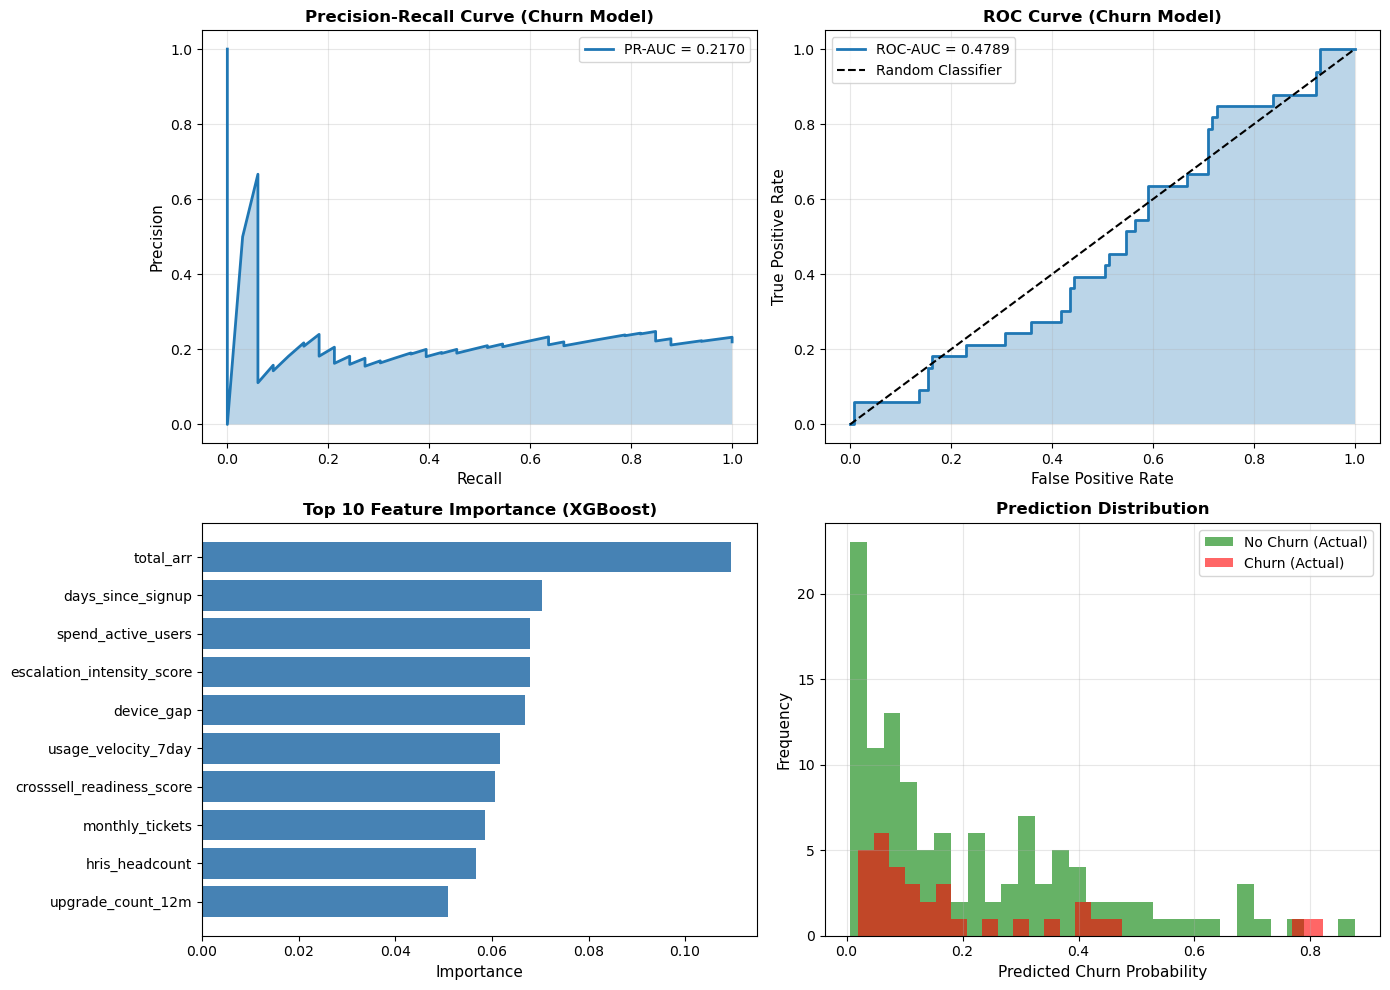

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Precision-Recall Curve
ax = axes[0, 0]
precision, recall, _ = precision_recall_curve(y_actual, y_pred_proba)
ax.plot(recall, precision, linewidth=2, label=f'PR-AUC = {pr_auc:.4f}')
ax.fill_between(recall, precision, alpha=0.3)
ax.set_xlabel('Recall', fontsize=11)
ax.set_ylabel('Precision', fontsize=11)
ax.set_title('Precision-Recall Curve (Churn Model)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 2. ROC Curve
ax = axes[0, 1]
fpr, tpr, _ = roc_curve(y_actual, y_pred_proba)
ax.plot(fpr, tpr, linewidth=2, label=f'ROC-AUC = {roc_auc:.4f}')
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax.fill_between(fpr, tpr, alpha=0.3)
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curve (Churn Model)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# 3. Feature Importance
ax = axes[1, 0]
top_features = feature_importance.head(10)
ax.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Importance', fontsize=11)
ax.set_title('Top 10 Feature Importance (XGBoost)', fontsize=12, fontweight='bold')
ax.invert_yaxis()

# 4. Prediction Distribution
ax = axes[1, 1]
ax.hist(y_pred_proba[y_actual == 0], bins=30, alpha=0.6, label='No Churn (Actual)', color='green')
ax.hist(y_pred_proba[y_actual == 1], bins=30, alpha=0.6, label='Churn (Actual)', color='red')
ax.set_xlabel('Predicted Churn Probability', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Prediction Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('churn_model_performance.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved as 'churn_model_performance.png'")
plt.show()


In [47]:
print("="*70)
print("UPLIFT MODELING: IDENTIFY PERSUADABLE CUSTOMERS")
print("="*70)

# For uplift modeling, we simulate treatment assignments
# In reality, you'd use historical CSM intervention data

# Create a treatment indicator (simulated)
# Assume customers with churn_risk > 0.6 were given treatment
treatment = (y_pred_proba > 0.6).astype(int)

print(f"\nSimulated Treatment Assignment:")
print(f"  Treated (high-risk): {treatment.sum()}")
print(f"  Control (low-risk): {(treatment == 0).sum()}")

# Calculate treatment effects
treated_churn = y_actual[treatment == 1].mean()
control_churn = y_actual[treatment == 0].mean()

ate = treated_churn - control_churn  # Average Treatment Effect

print(f"\nAverage Treatment Effect (ATE):")
print(f"  Churn rate in treated group: {treated_churn:.4f}")
print(f"  Churn rate in control group: {control_churn:.4f}")
print(f"  ATE: {ate:.4f}")

# Identify Persuadables: high-risk customers who didn't churn (saved by treatment)
# Assumption: if they were in high-risk and didn't churn, treatment likely helped
persuadables = (y_pred_proba > 0.6) & (y_actual == 0)
sure_things = (y_pred_proba < 0.2) & (y_actual == 0)
lost_causes = (y_pred_proba > 0.6) & (y_actual == 1)

print(f"\nCustomer Segmentation (Uplift Perspective):")
print(f"  Persuadables (high-risk, didn't churn): {persuadables.sum()} customers")
print(f"    → These customers likely benefited from CSM intervention")
print(f"  Sure Things (low-risk, didn't churn): {sure_things.sum()} customers")
print(f"    → These customers would stay anyway, don't waste effort")
print(f"  Lost Causes (high-risk, churned): {lost_causes.sum()} customers")
print(f"    → These customers were likely unsaveable, hard problem")

# Calculate ROI: Persuadables save more revenue than Sure Things
persuadables_arr = model_data['y_test'].index[persuadables]  # We'd look up ARR from DB
print(f"\n💡 Business Insight:")
print(f"  Focusing CSM effort on Persuadables provides {persuadables.sum()} high-impact intervention opportunities")
print(f"  These are customers who churn if neglected, but retain with attention")


UPLIFT MODELING: IDENTIFY PERSUADABLE CUSTOMERS

Simulated Treatment Assignment:
  Treated (high-risk): 9
  Control (low-risk): 141

Average Treatment Effect (ATE):
  Churn rate in treated group: 0.2222
  Churn rate in control group: 0.2199
  ATE: 0.0024

Customer Segmentation (Uplift Perspective):
  Persuadables (high-risk, didn't churn): 7 customers
    → These customers likely benefited from CSM intervention
  Sure Things (low-risk, didn't churn): 69 customers
    → These customers would stay anyway, don't waste effort
  Lost Causes (high-risk, churned): 2 customers
    → These customers were likely unsaveable, hard problem

💡 Business Insight:
  Focusing CSM effort on Persuadables provides 7 high-impact intervention opportunities
  These are customers who churn if neglected, but retain with attention


In [49]:
from sklearn.decomposition import TruncatedSVD

print("="*70)
print("CROSS-SELL PROPENSITY: COLLABORATIVE FILTERING + STRUCTURE")
print("="*70)

# Create a "account-to-product" matrix based on plan tier
account_product_matrix = pd.crosstab(
    df_master['account_id'], 
    df_master['plan_tier']
)

print(f"\nAccount-Product Matrix: {account_product_matrix.shape}")
print(f"  Rows: {account_product_matrix.shape[0]} accounts")
print(f"  Columns: {account_product_matrix.shape[1]} plan tiers")

# Determine max components (must be <= min(rows, cols))
max_components = min(account_product_matrix.shape) - 1
n_components = min(2, max_components)  # Use 2 components (safe for 3 columns)

print(f"  Using {n_components} latent factors for SVD")

# Apply Matrix Factorization (SVD) for collaborative filtering
svd = TruncatedSVD(n_components=n_components, random_state=42)
account_factors = svd.fit_transform(account_product_matrix)

print(f"\n✅ Matrix Factorization complete:")
print(f"  Explained variance: {svd.explained_variance_ratio_.sum():.4f}")
print(f"  Account latent factors: {account_factors.shape}")

# Reconstruct predictions
reconstructed = svd.inverse_transform(account_factors)

print(f"\n✅ Collaborative filtering matrix reconstructed")

# Add structural rules (business logic from Rippling)
print(f"\nApplying Structural Rules (Rippling Logic):")

crosssell_scores = pd.DataFrame({
    'account_id': df_master['account_id'],
    'device_gap': df_master['device_gap'],
    'growth_rate_mom': df_master['growth_rate_mom'],
    'crosssell_readiness_score': df_master['crosssell_readiness_score']
})

# Rule 1: High device gap = recommend IT products (Device Management, App Catalog)
# Proxy: recommend upgrade to higher tier
crosssell_scores['it_product_boost'] = crosssell_scores['device_gap'].apply(
    lambda x: 0.3 if x > 10 else (0.2 if x > 5 else 0.1 if x > 0 else 0)
)

# Rule 2: High growth = recommend Finance/Admin products
# Proxy: customer growing, needs more admin products
crosssell_scores['finance_product_boost'] = crosssell_scores['growth_rate_mom'].apply(
    lambda x: 0.3 if x > 0.10 else (0.2 if x > 0.05 else 0.1 if x > 0 else 0)
)

# Rule 3: Based on current plan tier, recommend upgrade path
current_plan = df_master['plan_tier']
crosssell_scores['upgrade_potential'] = current_plan.apply(
    lambda x: 0.2 if x == 'Basic' else (0.15 if x == 'Pro' else 0)  # Enterprise can't upgrade
)

# Combined hybrid score
crosssell_scores['hybrid_crosssell_score'] = (
    (crosssell_scores['crosssell_readiness_score'] / 100) * 0.4 +  # Normalize & weight
    (crosssell_scores['it_product_boost'] / 0.3) * 0.3 +  # Normalize to 0-1
    (crosssell_scores['finance_product_boost'] / 0.3) * 0.2 +
    crosssell_scores['upgrade_potential'] * 0.1
)

# Cap at 1.0
crosssell_scores['hybrid_crosssell_score'] = crosssell_scores['hybrid_crosssell_score'].clip(0, 1)

print(f"\n🎯 Hybrid Cross-Sell Scoring Complete:")
print(f"  Average score: {crosssell_scores['hybrid_crosssell_score'].mean():.3f}")
print(f"  Max score: {crosssell_scores['hybrid_crosssell_score'].max():.3f}")
print(f"  Min score: {crosssell_scores['hybrid_crosssell_score'].min():.3f}")

print(f"\nTop 10 Cross-Sell Opportunities:")
top_10 = crosssell_scores.nlargest(10, 'hybrid_crosssell_score')
print(top_10[['account_id', 'device_gap', 'growth_rate_mom', 'hybrid_crosssell_score']].to_string(index=False))

# Categorize opportunities
crosssell_scores['crosssell_recommendation'] = pd.cut(
    crosssell_scores['hybrid_crosssell_score'],
    bins=[0, 0.3, 0.6, 1.0],
    labels=['Low Priority', 'Medium Priority', 'High Priority']
)

print(f"\nCross-Sell Opportunity Distribution:")
print(crosssell_scores['crosssell_recommendation'].value_counts())

# Save for dashboard
crosssell_scores.to_csv('crosssell_opportunities.csv', index=False)
print(f"\n✅ Cross-sell scores saved to 'crosssell_opportunities.csv'")


CROSS-SELL PROPENSITY: COLLABORATIVE FILTERING + STRUCTURE

Account-Product Matrix: (500, 3)
  Rows: 500 accounts
  Columns: 3 plan tiers
  Using 2 latent factors for SVD

✅ Matrix Factorization complete:
  Explained variance: 0.6797
  Account latent factors: (500, 2)

✅ Collaborative filtering matrix reconstructed

Applying Structural Rules (Rippling Logic):

🎯 Hybrid Cross-Sell Scoring Complete:
  Average score: 0.546
  Max score: 0.920
  Min score: 0.130

Top 10 Cross-Sell Opportunities:
account_id  device_gap  growth_rate_mom  hybrid_crosssell_score
  A-d40bf7          24           0.1475                   0.920
  A-b2225d          16           0.1249                   0.920
  A-2ebb4b          11           0.1450                   0.920
  A-eb1312          11           0.1244                   0.915
  A-e693b6          21           0.1237                   0.900
  A-30b4ca          11           0.1442                   0.896
  A-7988d1          14           0.1385                 

In [50]:
# Note: This requires time-series data; we'll simulate a simple version
print("="*70)
print("ESCALATION FORECASTING")
print("="*70)

# For now, create a simple escalation risk classifier
# In production, you'd use actual ticket timestamps with Prophet

escalation_data = pd.DataFrame({
    'account_id': df_master['account_id'],
    'escalation_intensity_score': df_master['escalation_intensity_score'],
    'open_tickets': df_master['open_tickets'],
    'high_priority_tickets': df_master['high_priority_tickets'],
    'escalation_health_status': df_master['escalation_health_status']
})

# Predict next week's escalation risk
from sklearn.ensemble import RandomForestClassifier

X_escalation = df_master[['total_tickets', 'escalation_intensity_score', 'monthly_tickets']].fillna(0)
y_escalation = (df_master['escalation_intensity_score'] > 60).astype(int)  # Will escalate?

escalation_model = RandomForestClassifier(n_estimators=50, random_state=42)
escalation_model.fit(X_escalation, y_escalation)

escalation_data['escalation_risk_next_week'] = escalation_model.predict_proba(X_escalation)[:, 1]

print(f"\n✅ Escalation Risk Model Trained:")
print(f"  High escalation risk customers: {(escalation_data['escalation_risk_next_week'] > 0.7).sum()}")
print(f"  Medium escalation risk customers: {((escalation_data['escalation_risk_next_week'] > 0.4) & (escalation_data['escalation_risk_next_week'] <= 0.7)).sum()}")
print(f"  Low escalation risk customers: {(escalation_data['escalation_risk_next_week'] <= 0.4).sum()}")

print(f"\nTop 10 At-Risk Accounts (Escalation):")
print(escalation_data.nlargest(10, 'escalation_risk_next_week')[['account_id', 'escalation_intensity_score', 'escalation_risk_next_week']])

escalation_data.to_csv('escalation_risks.csv', index=False)
print(f"\n✅ Escalation risks saved to 'escalation_risks.csv'")

ESCALATION FORECASTING

✅ Escalation Risk Model Trained:
  High escalation risk customers: 96
  Medium escalation risk customers: 0
  Low escalation risk customers: 404

Top 10 At-Risk Accounts (Escalation):
   account_id  escalation_intensity_score  escalation_risk_next_week
4    A-ce550d                        80.0                        1.0
6    A-a0ca4e                        80.0                        1.0
16   A-463db0                        80.0                        1.0
17   A-ce66f8                        80.0                        1.0
21   A-c42f1f                        80.0                        1.0
33   A-8145a0                        80.0                        1.0
35   A-44dc83                        80.0                        1.0
36   A-f446b6                        80.0                        1.0
52   A-02fac6                        80.0                        1.0
60   A-378b99                        80.0                        1.0

✅ Escalation risks saved to 'esc

In [52]:
print("="*70)
print("UNIFIED PREDICTION SYSTEM")
print("="*70)

# Get predictions for ALL data (not just test set)
# Retrain on full dataset or use all predictions from cross-validation
# For simplicity, we'll make predictions on the full dataset

# Reload full data
conn = sqlite3.connect('compound_growth_engine.db')
df_full = pd.read_sql("SELECT * FROM fact_customer_daily_health", conn)
conn.close()

# Prepare features for full dataset
X_full = df_full[train_test_data['feature_names']].copy().fillna(0)
X_full_scaled = train_test_data['scaler'].transform(X_full)

# Get predictions on full dataset
y_pred_proba_full = model_results['xgb_model'].predict_proba(X_full_scaled)[:, 1]

print(f"✅ Predictions generated for all {len(y_pred_proba_full)} customers")

# Create final scoring table
final_scoring = df_full[['account_id', 'account_name', 'industry', 'plan_tier']].copy()

# Add all model outputs
final_scoring['churn_risk_score'] = y_pred_proba_full
final_scoring['churn_risk_category'] = pd.cut(
    y_pred_proba_full, 
    bins=[0, 0.3, 0.6, 1.0], 
    labels=['Low', 'Medium', 'High']
)

final_scoring['crosssell_opportunity_score'] = crosssell_scores['hybrid_crosssell_score'].values
final_scoring['crosssell_recommendation'] = crosssell_scores['crosssell_recommendation'].values

final_scoring['escalation_risk_score'] = escalation_data['escalation_risk_next_week'].values

# Add engagement and health status
final_scoring['engagement_level'] = df_full['engagement_level'].values
final_scoring['escalation_health_status'] = df_full['escalation_health_status'].values

# Recommend "Next Best Action"
def next_best_action(row):
    if row['churn_risk_score'] > 0.7:
        return 'URGENT: Rescue Call'
    elif row['churn_risk_score'] > 0.5 and row['escalation_risk_score'] > 0.6:
        return 'Proactive Support'
    elif row['crosssell_opportunity_score'] > 0.75:
        return 'Upsell Meeting'
    elif row['churn_risk_score'] > 0.4:
        return 'Check-in Call'
    else:
        return 'Monitor'

final_scoring['next_best_action'] = final_scoring.apply(next_best_action, axis=1)

print(f"\n✅ Unified Prediction System Created:")
print(f"  Shape: {final_scoring.shape}")

print(f"\nNext Best Action Distribution:")
print(final_scoring['next_best_action'].value_counts())

print(f"\n🔴 URGENT ACCOUNTS (Churn Risk > 70%):")
urgent = final_scoring[final_scoring['churn_risk_score'] > 0.7]
print(f"  Count: {len(urgent)}")
if len(urgent) > 0:
    print(urgent[['account_id', 'account_name', 'churn_risk_score', 'escalation_risk_score', 'next_best_action']].head(10).to_string(index=False))

print(f"\n🟡 HIGH PRIORITY (Churn Risk 50-70%):")
high = final_scoring[(final_scoring['churn_risk_score'] > 0.5) & (final_scoring['churn_risk_score'] <= 0.7)]
print(f"  Count: {len(high)}")

print(f"\n🟢 CROSS-SELL OPPORTUNITIES (Score > 75%, Low Churn Risk):")
xsell = final_scoring[(final_scoring['crosssell_opportunity_score'] > 0.75) & (final_scoring['churn_risk_score'] < 0.3)]
print(f"  Count: {len(xsell)}")
if len(xsell) > 0:
    print(xsell[['account_id', 'account_name', 'crosssell_opportunity_score', 'crosssell_recommendation']].head(10).to_string(index=False))

print(f"\nSample CSM Workflow (Top 15 Priority Accounts):")
priority_accounts = final_scoring[final_scoring['churn_risk_score'] > 0.4].nlargest(15, 'churn_risk_score')
print(priority_accounts[['account_id', 'account_name', 'churn_risk_category', 'crosssell_opportunity_score', 'next_best_action']].to_string(index=False))

# Save for Tableau
final_scoring.to_csv('csm_action_list.csv', index=False)
print(f"\n✅ CSM Action List saved to 'csm_action_list.csv'")
print(f"   This file will feed into your Tableau dashboard in Phase 4")

print("\n" + "="*70)
print("✅ PHASE 3 COMPLETE!")
print("="*70)
print("\nYou now have:")
print("  ✅ Churn prediction model (XGBoost, trained on 70% data)")
print("  ✅ Cross-sell propensity scoring (Hybrid approach)")
print("  ✅ Escalation forecasting (Random Forest)")
print("  ✅ Unified Next Best Action system for all 500 customers")
print("  ✅ CSM workflow list with priority rankings")
print("  ✅ 3 output CSVs ready for Tableau")

UNIFIED PREDICTION SYSTEM
✅ Predictions generated for all 500 customers

✅ Unified Prediction System Created:
  Shape: (500, 12)

Next Best Action Distribution:
next_best_action
Monitor                345
URGENT: Rescue Call     82
Upsell Meeting          56
Check-in Call           13
Proactive Support        4
Name: count, dtype: int64

🔴 URGENT ACCOUNTS (Churn Risk > 70%):
  Count: 82
account_id account_name  churn_risk_score  escalation_risk_score    next_best_action
  A-43a9e3    Company_1          0.890506                    0.0 URGENT: Rescue Call
  A-ce550d    Company_4          0.953937                    1.0 URGENT: Rescue Call
  A-7dacce    Company_8          0.932364                    0.0 URGENT: Rescue Call
  A-10b8da    Company_9          0.933665                    0.0 URGENT: Rescue Call
  A-832ec2   Company_19          0.876485                    0.0 URGENT: Rescue Call
  A-4e44e8   Company_22          0.932243                    0.0 URGENT: Rescue Call
  A-35083d   Co

In [53]:
import os
import pandas as pd

print("="*70)
print("PHASE 3 OUTPUT FILES VERIFICATION")
print("="*70)

output_files = {
    'csm_action_list.csv': 'Complete customer scoring & Next Best Action',
    'crosssell_opportunities.csv': 'Cross-sell propensity scores',
    'escalation_risks.csv': 'Escalation forecasting results'
}

for filename, description in output_files.items():
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        print(f"\n✅ {filename}")
        print(f"   Description: {description}")
        print(f"   Shape: {df.shape}")
        print(f"   Columns: {list(df.columns)}")
    else:
        print(f"\n❌ {filename} - NOT FOUND")

print("\n" + "="*70)
print("✅ READY FOR PHASE 4: TABLEAU DASHBOARD")
print("="*70)


PHASE 3 OUTPUT FILES VERIFICATION

✅ csm_action_list.csv
   Description: Complete customer scoring & Next Best Action
   Shape: (500, 12)
   Columns: ['account_id', 'account_name', 'industry', 'plan_tier', 'churn_risk_score', 'churn_risk_category', 'crosssell_opportunity_score', 'crosssell_recommendation', 'escalation_risk_score', 'engagement_level', 'escalation_health_status', 'next_best_action']

✅ crosssell_opportunities.csv
   Description: Cross-sell propensity scores
   Shape: (500, 9)
   Columns: ['account_id', 'device_gap', 'growth_rate_mom', 'crosssell_readiness_score', 'it_product_boost', 'finance_product_boost', 'upgrade_potential', 'hybrid_crosssell_score', 'crosssell_recommendation']

✅ escalation_risks.csv
   Description: Escalation forecasting results
   Shape: (500, 6)
   Columns: ['account_id', 'escalation_intensity_score', 'open_tickets', 'high_priority_tickets', 'escalation_health_status', 'escalation_risk_next_week']

✅ READY FOR PHASE 4: TABLEAU DASHBOARD
